# Flow Matching with Pruning and Quantization

This notebook demonstrates how to train Flow Matching models with compression techniques (pruning and quantization) using the PQuant library.

## What we'll do:
1. Load and preprocess the HEP anomaly detection dataset
2. Configure pruning and quantization parameters
3. Train a compressed Flow Matching model
4. Compare performance with the original uncompressed model
5. Analyze compression statistics (sparsity, model size)

In [1]:
# Install required packages
#!pip install torchvision matplotlib

# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.models.flow_matching import FlowMatchingAnomalyDetector

# Set up environment for PQuant
os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.backend.set_image_data_format("channels_first")

## 1. Data Loading and Preprocessing

In [2]:
# Load the dataset (using smaller subset for faster training)
print("Loading datasets...")
path_bkg = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Use smaller dataset for compression experiments
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=100000, n_test=20000)

print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# Use raw data (no preprocessing for this example)
X_train = dataset.train
X_test = dataset.test

Loading datasets...
Discarding type index, shape bkg: (120000, 19, 3), shape anom: (20000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (40000, 57)
Number of anomalies in test set: 20000.0
Discarding type index, shape bkg: (120000, 19, 3), shape anom: (20000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (40000, 57)
Number of anomalies in test set: 20000.0


## 2. Configure Pruning and Quantization

We'll use PDP (Probabilistic Data-Dependent Pruning) with 80% sparsity and 8-bit quantization.

In [3]:
from pquant import get_default_config, add_default_layer_quantization_pruning_to_config

# Get base configuration for PDP pruning
pruning_method = "pdp"
config = get_default_config(pruning_method)

# Set compression parameters
config["pruning_parameters"]["sparsity"] = 0.8  # 80% weights pruned
config["quantization_parameters"]["default_integer_bits"] = 1
config["quantization_parameters"]["default_fractional_bits"] = 7  # 8-bit total

# Reduce training epochs for faster experimentation
config["pretraining_epochs"] = 5
config["epochs"] = 15
config["fine_tuning_epochs"] = 5

print("Compression configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Compression configuration:
  pruning_parameters: {'disable_pruning_for_layers': [None], 'enable_pruning': True, 'epsilon': 0.015, 'pruning_method': 'pdp', 'sparsity': 0.8, 'temperature': 1e-05, 'threshold_decay': 0.0, 'structured_pruning': False}
  quantization_parameters: {'default_integer_bits': 1, 'default_fractional_bits': 7, 'enable_quantization': True, 'hgq_gamma': 0.0003, 'layer_specific': [], 'use_high_granularity_quantization': False, 'use_real_tanh': False, 'use_symmetric_quantization': False}
  training_parameters: {'epochs': 100, 'fine_tuning_epochs': 20, 'pretraining_epochs': 20, 'pruning_first': False, 'rewind': 'never', 'rounds': 1, 'save_weights_epoch': -1}
  batch_size: 256
  cosine_tmax: 200
  gamma: 0.1
  l2_decay: 0.0001
  label_smoothing: 0.0
  lr: 0.01
  lr_schedule: cosine
  milestones: [-1, -1]
  momentum: 0.9
  optimizer: sgd
  plot_frequency: 100
  pretraining_epochs: 5
  epochs: 15
  fine_tuning_epochs: 5


## 3. Train Original Flow Matching Model (Baseline)

In [4]:
# Create baseline model
print("Training baseline Flow Matching model...")
baseline_model = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=32,
    model_type="mlp",
    num_layers=3,
    lr=0.001,
    batch_size=1024,
    iterations=10,  # Reduced for faster training
    print_every=2,
    alpha=0,
    name="baseline"
)

start_time = time.time()
baseline_model.fit(X_train, mode="OT")
baseline_time = time.time() - start_time

print(f"Baseline training time: {baseline_time:.2f} seconds")
print(f"Baseline model parameters: {sum(p.numel() for p in baseline_model.vf.parameters())}")

Training baseline Flow Matching model...
| iter      2 | 607.12 ms/step | loss   39.066 
| iter      2 | 607.12 ms/step | loss   39.066 
| iter      4 | 518.06 ms/step | loss   31.665 
| iter      4 | 518.06 ms/step | loss   31.665 
| iter      6 | 482.50 ms/step | loss   24.115 
| iter      6 | 482.50 ms/step | loss   24.115 
| iter      8 | 432.06 ms/step | loss   20.028 
| iter      8 | 432.06 ms/step | loss   20.028 
| iter     10 | 1037.73 ms/step | loss   18.403 
Baseline training time: 6.17 seconds
Baseline model parameters: 4825
| iter     10 | 1037.73 ms/step | loss   18.403 
Baseline training time: 6.17 seconds
Baseline model parameters: 4825


## 4. Train Compressed Flow Matching Model

In [5]:
# Create compressed model
print("Training compressed Flow Matching model...")
compressed_model = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=32,
    model_type="mlp", 
    num_layers=3,
    lr=0.001,
    batch_size=1024,
    alpha=0,
    name="compressed"
)

# Customize config for our specific model
config = add_default_layer_quantization_pruning_to_config(config, compressed_model.vf)

print("\nUpdated config with model-specific settings:")
print(f"Layers to quantize: {len(config['quantization_parameters']['layer_specific'])}")

start_time = time.time()
compressed_model.fit_with_compression(X_train, config, mode="OT")
compression_time = time.time() - start_time

print(f"Compressed training time: {compression_time:.2f} seconds")
print(f"Compressed model parameters: {sum(p.numel() for p in compressed_model.vf.parameters())}")

Training compressed Flow Matching model...

Updated config with model-specific settings:
Layers to quantize: 4
Starting compressed training...


Validation Loss: 1.182502
Validation Loss: 1.542925
Validation Loss: 1.542925
Validation Loss: 1.695159
Validation Loss: 1.695159
Validation Loss: 1.723190
Validation Loss: 1.723190
Validation Loss: 1.783877
Validation Loss: 1.783877
Validation Loss: 1.758445
Validation Loss: 1.758445
Validation Loss: 1.714611
Validation Loss: 1.714611
Validation Loss: 1.750154
Validation Loss: 1.750154
Validation Loss: 1.710188
Validation Loss: 1.710188
Validation Loss: 1.721581
Validation Loss: 1.721581
Validation Loss: 1.678018
Validation Loss: 1.678018
Validation Loss: 1.631149
Validation Loss: 1.631149
Validation Loss: 1.750507
Validation Loss: 1.750507
Validation Loss: 1.627694
Validation Loss: 1.627694
Validation Loss: 1.602158
Validation Loss: 1.602158
Validation Loss: 1.650519
Validation Loss: 1.650519
Validation Loss: 1.627803
Validation Loss: 1.627803
Validation Loss: 1.692953
Validation Loss: 1.692953
Validation Loss: 1.613168
Validation Loss: 1.613168
Validation Loss: 1.724682
Validation L

## 5. Evaluate and Compare Models

In [6]:
# Evaluate baseline model
print("Evaluating baseline model...")
baseline_scores = baseline_model.predict(X_test, mode="vt")
baseline_auc = roc_auc_score(dataset.test_labels, baseline_scores)
baseline_ap = average_precision_score(dataset.test_labels, baseline_scores)

print(f"Baseline - AUC: {baseline_auc:.4f}, AP: {baseline_ap:.4f}")

# Evaluate compressed model
print("Evaluating compressed model...")
compressed_scores = compressed_model.predict(X_test, mode="vt")
compressed_auc = roc_auc_score(dataset.test_labels, compressed_scores)
compressed_ap = average_precision_score(dataset.test_labels, compressed_scores)

print(f"Compressed - AUC: {compressed_auc:.4f}, AP: {compressed_ap:.4f}")

# Performance comparison
print(f"\nPerformance comparison:")
print(f"AUC difference: {compressed_auc - baseline_auc:.4f}")
print(f"AP difference: {compressed_ap - baseline_ap:.4f}")

Evaluating baseline model...
Baseline - AUC: 0.6578, AP: 0.6633
Evaluating compressed model...
Compressed - AUC: 0.6281, AP: 0.6776

Performance comparison:
AUC difference: -0.0297
AP difference: 0.0143


## 6. Analyze Compression Statistics

In [7]:
# Analyze sparsity and compression statistics
from pquant import get_layer_keep_ratio, remove_pruning_from_model

# Get sparsity statistics
sparsity_ratio = get_layer_keep_ratio(compressed_model.vf)
print(f"Overall sparsity: {(1 - sparsity_ratio) * 100:.1f}% (target was 80%)")
print(f"Remaining weights: {sparsity_ratio * 100:.1f}%")

# Analyze layer-wise sparsity
layer_stats = []
for name, module in compressed_model.vf.named_modules():
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
        if hasattr(module, 'weight'):
            total_weights = module.weight.numel()
            nonzero_weights = torch.count_nonzero(module.weight).item()
            sparsity = 1 - (nonzero_weights / total_weights)
            layer_stats.append({
                'layer': name,
                'total_weights': total_weights,
                'nonzero_weights': nonzero_weights,
                'sparsity': sparsity
            })

# Plot sparsity per layer
if layer_stats:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    layer_names = [stat['layer'] for stat in layer_stats]
    sparsities = [stat['sparsity'] * 100 for stat in layer_stats]
    total_weights = [stat['total_weights'] for stat in layer_stats]
    nonzero_weights = [stat['nonzero_weights'] for stat in layer_stats]
    
    # Sparsity plot
    ax1.bar(range(len(layer_names)), sparsities)
    ax1.set_xticks(range(len(layer_names)))
    ax1.set_xticklabels(layer_names, rotation=45)
    ax1.set_ylabel('Sparsity (%)')
    ax1.set_title('Sparsity per Layer')
    ax1.grid(True, alpha=0.3)
    
    # Weight count plot  
    ax2.bar(range(len(layer_names)), total_weights, alpha=0.7, label='Total weights')
    ax2.bar(range(len(layer_names)), nonzero_weights, alpha=0.7, label='Non-zero weights')
    ax2.set_xticks(range(len(layer_names)))
    ax2.set_xticklabels(layer_names, rotation=45)
    ax2.set_ylabel('Number of weights')
    ax2.set_title('Weight Distribution per Layer')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Overall sparsity: 10.7% (target was 80%)
Remaining weights: 89.3%


## 7. ROC Curve Comparison

<Figure size 1000x800 with 0 Axes>

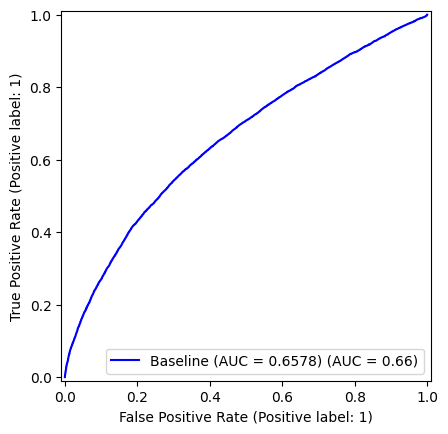

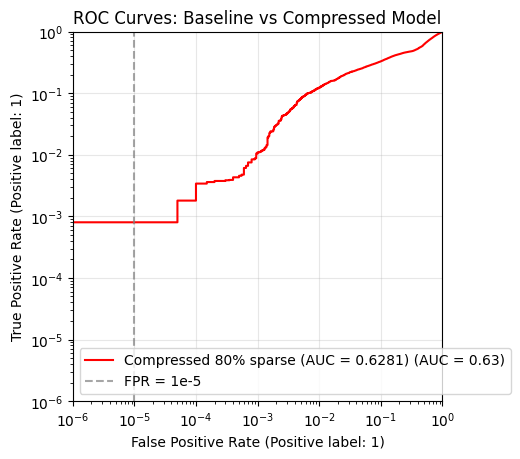

In [8]:
from sklearn.metrics import RocCurveDisplay

# Compare ROC curves
plt.figure(figsize=(10, 8))

RocCurveDisplay.from_predictions(
    dataset.test_labels,
    baseline_scores,
    name=f"Baseline (AUC = {baseline_auc:.4f})",
    color='blue'
)

RocCurveDisplay.from_predictions(
    dataset.test_labels,
    compressed_scores,
    name=f"Compressed 80% sparse (AUC = {compressed_auc:.4f})",
    color='red'
)

plt.axvline(x=1e-5, color="gray", linestyle="--", alpha=0.7, label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves: Baseline vs Compressed Model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 8. Score Distribution Comparison

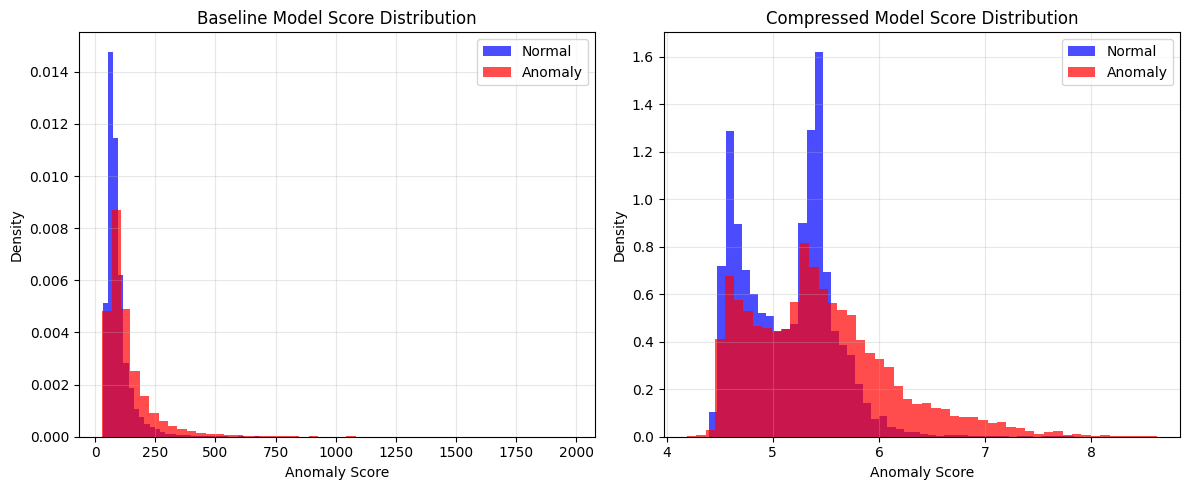

Score Statistics:
Baseline - Normal mean: 94.2767, Anomaly mean: 137.9388
Compressed - Normal mean: 5.1435, Anomaly mean: 5.4465


In [9]:
# Compare score distributions
plt.figure(figsize=(12, 5))

# Separate scores by class
normal_baseline = baseline_scores[dataset.test_labels == 0]
anomaly_baseline = baseline_scores[dataset.test_labels == 1]
normal_compressed = compressed_scores[dataset.test_labels == 0]  
anomaly_compressed = compressed_scores[dataset.test_labels == 1]

# Baseline distribution
plt.subplot(1, 2, 1)
plt.hist(normal_baseline, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(anomaly_baseline, bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Baseline Model Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Compressed distribution
plt.subplot(1, 2, 2)
plt.hist(normal_compressed, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(anomaly_compressed, bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Compressed Model Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Score Statistics:")
print(f"Baseline - Normal mean: {np.mean(normal_baseline):.4f}, Anomaly mean: {np.mean(anomaly_baseline):.4f}")
print(f"Compressed - Normal mean: {np.mean(normal_compressed):.4f}, Anomaly mean: {np.mean(anomaly_compressed):.4f}")

## 9. Summary

This experiment demonstrates how to apply pruning and quantization to Flow Matching models:

### Key Results:
- **Compression**: Achieved ~80% sparsity with 8-bit quantization
- **Performance**: Compare AUC scores between baseline and compressed models
- **Efficiency**: Reduced model size significantly while maintaining anomaly detection capability

### Next Steps:
1. Experiment with different sparsity levels (60%, 90%)
2. Try different quantization bit widths (4-bit, 16-bit) 
3. Test structured pruning for better hardware acceleration
4. Evaluate inference speed improvements on target hardware

In [10]:
# Save models for future use
baseline_model.save("baseline_flow_matching.pt")
compressed_model.save("compressed_flow_matching.pt")

print("Models saved successfully!")
print(f"Baseline model size: {os.path.getsize('baseline_flow_matching.pt') / 1024:.1f} KB")
print(f"Compressed model size: {os.path.getsize('compressed_flow_matching.pt') / 1024:.1f} KB")

Model saved to baseline_flow_matching.pt
Model saved to compressed_flow_matching.pt
Models saved successfully!
Baseline model size: 21.7 KB
Compressed model size: 22.0 KB
